In [7]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
# from sklearn.cluster import OPTICS

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM #CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Load the model (4s cadence, 128 point segments)

In [3]:
weights_dir = "../../../model_weights/model_2020-12-21_20-11-39.h5" #exp171

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 20

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'CuDNNLSTM'

## Load data (segments)

In [3]:
segments_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'
errors_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_errors_sum_bin.pkl'
ids_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_ids_sum_bin.pkl'

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

## Try reconstruction (shape)

In [ ]:
try_first_x = len(segments)
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    print(segment_index)
    clear_output(wait=True)
plot_index = np.copy(try_first_x)-1

86705


In [ ]:
reconstructions_dir = '../../../data_GRS1915/reconstructions_model_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(reconstructions_dir, 'wb') as f:
    pickle.dump(reconstructions, f)
print("Reconstructions saved to: ", reconstructions_dir)

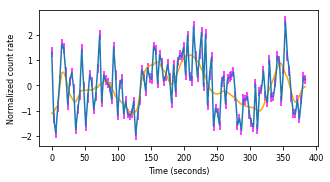

In [35]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

plt.errorbar(np.linspace(0,384, original_dim), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,384, original_dim), reconstructions[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.show()
if plot_index>0:
    plot_index-=1

## Encode the data set

In [36]:
trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
segment_encoding = np.zeros((segments.shape[0], 2, 20))
for seg_ind, seg in enumerate(segments):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

468201


In [37]:
segment_encoding_dir = '../../../data_GRS1915/segment_encoding_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'wb') as f:
    pickle.dump(segment_encoding, f)
print("Encodings saved to: ", segment_encoding_dir)

Encodings saved to:  ../../../data_GRS1915/segment_encoding_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl


# Load the model (1s cadence, 128 point segments)

In [8]:
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5" #exp175

class Sampling_func(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128 # input dimension
intermediate_dim = 1024 # number of LSTM cells
latent_dim = 20 # dimension of the latent code

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='Encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False, name="Encoder_LSTM")(original_inputs)
z_mean = layers.Dense(latent_dim, name='Latent_mean')(x)
z_log_var = layers.Dense(latent_dim, name='Latent_log_variance')(x)
z = Sampling_func(name="Sampler")((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='Decoder_input')
x = layers.RepeatVector(original_dim, name="Expand_to_decoder_shape")(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True, name="Decoder_LSTM")(x)
outputs = layers.TimeDistributed(layers.Dense(1, name="Dense"), name="Collapse_to_output_shape")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

## Load data (segments)

In [3]:
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
errors_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_errors_sum_bin.pkl'
ids_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

## Try reconstruction (shape)

In [ ]:
try_first_x = len(segments)
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    print(segment_index)
    clear_output(wait=True)
plot_index = np.copy(try_first_x)-1

327753


In [ ]:
# reconstructions_dir = '../../../data_GRS1915/reconstructions_model_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
# with open(reconstructions_dir, 'wb') as f:
#     pickle.dump(reconstructions, f)
# print("Reconstructions saved to: ", reconstructions_dir)

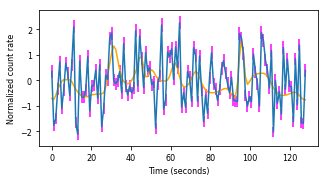

In [48]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

plt.errorbar(np.linspace(0,128, original_dim), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,128, original_dim), reconstructions[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.show()
if plot_index>0:
    plot_index-=1

## Encode the data set

In [49]:
trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
segment_encoding = np.zeros((segments.shape[0], 2, 20))
for seg_ind, seg in enumerate(segments):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

474470


In [50]:
segment_encoding_dir = '../../../data_GRS1915/segment_encoding_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'wb') as f:
    pickle.dump(segment_encoding, f)
print("Encodings saved to: ", segment_encoding_dir)

Encodings saved to:  ../../../data_GRS1915/segment_encoding_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl


# Plot the model

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import umap
# from sklearn.mixture import GaussianMixture
# from scipy import stats
# from sklearn.cluster import OPTICS

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import CuDNNLSTM #CuDNNLSTM

from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [8]:
# weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5" #exp175

class Sampling_func(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128 # input dimension
intermediate_dim = 1024 # number of LSTM cells
latent_dim = 20 # dimension of the latent code

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='Encoder_input')
input_err = Input(shape=(original_dim,1))
x = CuDNNLSTM(intermediate_dim, return_sequences=False, name="Encoder_LSTM")(original_inputs)
z_mean = layers.Dense(latent_dim, name='Latent_mean')(x)
z_log_var = layers.Dense(latent_dim, name='Latent_log_variance')(x)
z = Sampling_func(name="Sampler")((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='Decoder_input')
x = layers.RepeatVector(original_dim, name="Expand_to_decoder_shape")(latent_inputs)
x = CuDNNLSTM(intermediate_dim, return_sequences=True, name="Decoder_LSTM")(x)
outputs = layers.TimeDistributed(layers.Dense(1), name="Collapse_to_output_shape")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs], outputs=outputs, name='vae') # removed input_err from inputs

# vae.load_weights(weights_dir)

In [9]:
from tensorflow.keras.utils import plot_model

# plot_model(decoder, to_file='figures/model_plot_decoder_20.png', show_shapes=True, show_layer_names=True)
# plot_model(vae, to_file='figures/model_plot_vae_20.png', show_shapes=True, show_layer_names=True)

In [10]:
plot_model(vae, to_file='model.eps', show_shapes=True, show_layer_names=True, expand_nested=True)

ValueError: Cannot embed the 'eps' image format

In [8]:
# from tensorflow.keras.utils import plot_model

# plot_model(decoder, to_file='figures/model_plot_decoder_20.eps', show_shapes=True, show_layer_names=True)
# plot_model(vae, to_file='figures/model_plot_vae_20.eps', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
